In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image

In [6]:
labels_csv = pd.read_csv("dog-breed-identification/labels.csv")
labels_csv[:2]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo


In [7]:
unique_breeds = np.unique(labels_csv['breed'].to_numpy())
len(unique_breeds)

120

In [8]:
# sett path of images to id's of dog
path_of_images = "dog-breed-identification/train/"
filenames = [path_of_images + i + '.jpg' for i in labels_csv['id'] ]
filenames[:2]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

In [9]:
# check id's and actual images/data is same or note
if len(filenames) == len(os.listdir('dog-breed-identification/train')):
    print("data is equale")
else:
    print("not equale")

data is equale


In [10]:
# get labels from csv as numpy array
labels = labels_csv['breed'].to_numpy()
labels[:2]

array(['boston_bull', 'dingo'], dtype=object)

In [11]:
# convert labels into boolean/true-false
boolean_labels = [unique_breeds == label for label in labels]
boolean_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

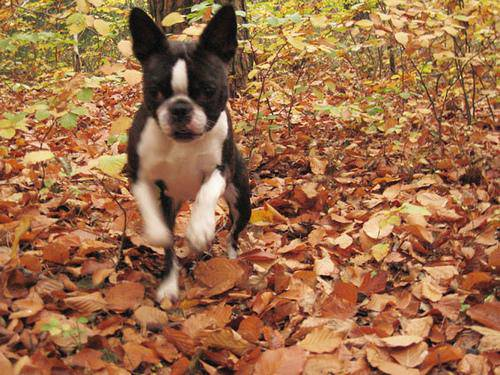

In [12]:
# viwe image giving the path of image
Image(filenames[0])

In [13]:
# create validation set and trainig set
from sklearn.model_selection import train_test_split

X = filenames
Y = boolean_labels

# split data 

X_train, X_val, Y_train, Y_val = train_test_split(X[:1000],
                                                  Y[:1000],
                                                  test_size=0.2,
                                                  random_state=42)

In [10]:
# one mor way to convert image into tensor

image = plt.imread(filenames[0])
image = tf.constant(image)
image[0]

<tf.Tensor: shape=(500, 3), dtype=uint8, numpy=
array([[109,  46,   0],
       [153,  91,  40],
       [180, 120,  68],
       ...,
       [176, 144,  71],
       [189, 157,  84],
       [214, 182, 109]], dtype=uint8)>

In [14]:
# create fix image size 
IMG_SIZE = 224

In [15]:
# create function to read images and convert into tensor and resize into 244

def img_processing(image_path):
    
    # get all images
    image = tf.io.read_file(image_path)
    
    # convert images into tensor with 3 colour chanels(red, green, blue)
    image = tf.image.decode_jpeg(contents = image,
                                 channels = 3)
    
    # convert data type into float 
    image = tf.image.convert_image_dtype(image,tf.float32)

    
    # resize images in to 244*244
    image = tf.image.resize(image,
                            size=[IMG_SIZE,IMG_SIZE])
        
    return image

#img_processing(filenames[0])

In [16]:
# create a function that return processed image and label as tupale

def get_image_label(image, label):
    
    image = img_processing(image)
    return image, label

In [17]:
# create a function thate turne images and boolean_labels into batches

def create_data_batches(x, y = None, batch_size = 32, val_data=False, test_data=False):
    
    # create test data that dos not requred labels/y data
    if test_data:
        print("creating test data")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x)) # converting dataset
        data_batch = data.map(img_processing).batch(batch_size)
        return data_batch
    
    # create validation data 
    elif val_data:
        print("creating validation data")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    
    # create training data
    else:
        print("creating training data")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                 tf.constant(y)))
        # shuffling data for better training
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
        
        

In [18]:
# create train and validation data batch

train_data = create_data_batches(X_train,
                                 Y_train)
val_data = create_data_batches(X_val,
                              Y_val,
                              val_data=True)
train_data

creating training data
creating validation data


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [19]:
# input shape model takes
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# set output shape model gives
OUTPUT_SHAPE = 120 #len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [17]:
# create a function which builds a "Keras" model

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("bulding model with", model_url)
  
  # step the model layers
  model = tf.keras.Sequential([
          hub.KerasLayer(model_url), # layer 1 (input layer)
          tf.keras.layers.Dense(units = output_shape,
                                activation = 'softmax') # layer 2 (output layer)
  ])

  # compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
      
  )

  # build the model
  model.build(input_shape)
  return model

In [18]:
model = create_model()
model.summary()

bulding model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [19]:
# load tensorboard notebook 
%load_ext tensorboard

##create a function that build tensorborad call back

import datetime
def create_tensorborad_callback():
    
    # create log directory in pc
    logdir = os.path.join("logs", # pass the path
                          # makit so the log get tracked with date
                          datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

    return tf.keras.callbacks.TensorBoard(logdir)


In [20]:
# create arly stoping callback

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 3)


In [21]:
NUM_EPOCHS = 100 

In [22]:
## create a function that build, train and return the model

def train_model(train_data, val_data):
    
    #create model
    model = create_model()
    
    # create new tensorboard session
    tensorboard = create_tensorborad_callback()
    
    # fit the model by passing our callback data
    model.fit(x = train_data,
              epochs = NUM_EPOCHS,
              validation_data = val_data,
              validation_freq = 1,
              callbacks = [tensorboard, early_stopping])
    
    # return the model
    return model
    
    

In [40]:
mdel =train_model(train_data, val_data)

bulding model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 57s 2s/step - loss: 4.6076 - accuracy: 0.0763 - val_loss: 3.4220 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 47s 2s/step - loss: 1.6342 - accuracy: 0.6913 - val_loss: 2.1276 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 46s 2s/step - loss: 0.5631 - accuracy: 0.9413 - val_loss: 1.6653 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 46s 2s/step - loss: 0.2485 - accuracy: 0.9862 - val_loss: 1.4887 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 46s 2s/step - loss: 0.1454 - accuracy: 0.9975 - val_loss: 1.3995 - val_accuracy: 0.6600
Epoch 6/100
25/25 [==============================] - 46s 2s/step - loss: 0.1007 - accuracy: 0.9987 - val_loss: 1.3550 - val_accuracy: 0.6550
Epoch 7/100
25/25 [===

In [24]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7880), started 2:51:41 ago. (Use '!kill 7880' to kill it.)

In [42]:
prediction = model.predict(val_data,
                           verbose = 1) # it shows us graphich off processing time


7/7 [==============================] - 10s 1s/step


In [43]:
# printing first prediction

print(f"confident about prediction {np.max(prediction[0])} \n dog name predicted = {unique_breeds[np.argmax(prediction[0])]}")

confident about prediction 0.08847402036190033 
 dog name predicted = yorkshire_terrier


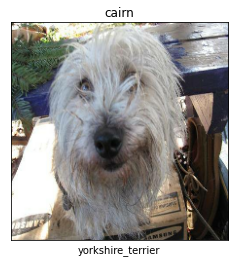

In [50]:
# viwe prediction image

i, l = next(val_data.as_numpy_iterator())

index = 0
plt.imshow(i[index])
plt.title(unique_breeds[np.argmax(l[index])])
plt.xticks([])
plt.yticks([])
plt.xlabel(unique_breeds[np.argmax(prediction[0])])
plt.show()

In [2]:
## saving and realoading model

def save_model(model, sufix=None):
    
    # create modeldir path for model
    modeldir = os.path.join('model_save',
                            datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S"))
    
    model_path = modeldir + '-' + sufix + '.h5' # save format model
    print("model saved at", model_path)
    model.save(model_path)
    return model_path

def load_model(model_path):
    
    print("model loded from",model_path)
    
    model = tf.keras.models.load_model(model_path,
                                       custom_objects = {'KerasLayer' : hub.KerasLayer})
    return model

In [27]:
path_ = save_model(model,"delete")

model saved at model_save\20-07-29-23-12-38-delete.h5


In [20]:
loded_model = load_model("model_save/fuliy_loded.h5")

model loded from model_save/fuliy_loded.h5


In [21]:
loded_model.predict(create_data_batches(X_train,test_data=True), verbose=1)

creating test data
25/25 [==============================] - 39s 2s/step


array([[1.37286715e-05, 9.85775957e-12, 5.92673750e-08, ...,
        1.14775895e-08, 7.15719978e-07, 6.28911891e-08],
       [3.38033802e-11, 2.36238926e-13, 2.27677745e-16, ...,
        2.99562307e-16, 7.60870554e-15, 2.60966839e-18],
       [5.01432174e-10, 1.28367678e-10, 3.87013251e-12, ...,
        2.55068861e-12, 1.06133852e-11, 6.21024725e-08],
       ...,
       [8.02614475e-10, 2.48415631e-06, 1.91825809e-12, ...,
        7.85259932e-13, 2.35806451e-14, 1.73878342e-11],
       [1.39647655e-10, 1.15235477e-11, 2.84774045e-11, ...,
        1.61826646e-11, 1.13614522e-08, 1.05948317e-07],
       [4.29706531e-17, 3.52347283e-11, 3.70758372e-12, ...,
        4.79711693e-09, 5.12980023e-06, 1.15691744e-12]], dtype=float32)

In [22]:
loded_model.evaluate(train_data)

25/25 [==============================] - 38s 2s/step - loss: 0.0029 - accuracy: 1.0000


[0.002900486965663731, 1.0]